# LIBRARIES

In [2]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from random import choice
from collections import deque
import networkx as nx
import pandas as pd

### Working on wikigraph.csv

We imported the reduced csv file containing for each single edge in the graph the starting node (Named Source) and the final node (Named Target). To obtain a correct display we used a separator with respect to the tab and subsequently we renamed the two columns 0,1 as Source and Target.

In [3]:
graph = pd.read_csv("wikigraph_reduced.csv", sep='\t', usecols =["0","1"]) #Read file csv with separator \t
graph.columns = ["Source","Target"] #Rename our columns
graph.head()

,Source,Target
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


### Working on page names

We have uploaded the Text file containing the names of each single page. Once loaded, to obtain a correct view, we wanted to split the single column containing both the name of the page and the node associated with the page into two separate columns.

In [4]:
data_name = pd.read_csv("Names.txt",sep="\t", names = ["Page Names"]) #Read file csv with separator \t
node =[] #Create a empty list for node
page= [] ##Create a empty list for node
for i in (data_name["Page Names"]): #We extract in each row from single column node and page
    node.append(i.split()[0]) #Split the single column and take the first element (NODE)
    page.append(" ".join(i.split()[1:])) #From the second element we have the name of page
data_name["Node"] = node #Create new column for Node
data_name["Pages"] = page #Create new column for pages
data_name = data_name.drop(["Page Names"], axis=1).set_index("Node") #Drop our original column and set our index in colun node
data_name.head()

,Pages
Node,
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem


### Working on topcast categories

Finally, we uploaded the text file containing the list of pages associated with this category for each single category. Also in this case for a correct visualization we have carried out various operations. Once you have read the text file with separator and division into columns. We then worked on the two columns, on the Category column we deleted the initial part of the string for each row while for the PageList column we split the pages and created a list. We have also only considered categories with a number of articles between 5000 and 30000 as required by the Homework.

In [7]:
data_cat = pd.read_csv('Categories.txt',sep=';', names = ["Category","PageList"]) #Read file csv with separator ";"
data_cat['Category'] = data_cat['Category'].map(lambda x: x.lstrip('Category:').rstrip('aAbBcC')) #modify the Category column by removing the initial part of the string "Category:" for each row
data_cat['PageList'] = data_cat['PageList'].map(lambda x: x.split()) #modify the PageList column by splitting our string of pageList in a list
data_cat = data_cat[(data_cat['PageList'].map(len) >= 5000) & (data_cat['PageList'].map(len) <= 30000)].reset_index() #Remove all Category with a number of Page lower than 5000 and higher than 30000
data_cat = data_cat.drop("index", axis = 1)
data_cat

,Category,PageList
0,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295..."
1,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280..."
2,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269..."
3,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268..."
4,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269..."
5,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,..."
6,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,..."
7,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306..."
8,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233..."
9,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,..."


We have decided to create a new data frame containing the category of belonging for each article. Subsequently we created a dictionary containing the individual articles as keys and the categories of belonging as values for each key. We did it all because one article might belong to a single category or multiple ones. In the case of multiple appearance, we have to break the ties uniformly at random. We have in fact modified the dictionary created by randomly choosing the category it belongs to for each article. Subsequently we obtained the reverse dictionary by choosing the various categories as keys and the list of pages associated with them as values for each key and finally we obtained a new dataframe

In [8]:
df_article = pd.concat([pd.DataFrame(data = {'Articles': data_cat.loc[i].PageList, 
                                             'Category': data_cat.loc[i].Category}) for i in data_cat.index], 
                       ignore_index=True) #Create a new datagrame where for each article we report the specific category

In [9]:
df_article

,Articles,Category
0,22860,English_footballers
1,28411,English_footballers
2,28961,English_footballers
3,28979,English_footballers
4,29264,English_footballers
...,...,...
198953,1790533,Place_of_birth_missing_(living_people)
198954,1790602,Place_of_birth_missing_(living_people)
198955,1790605,Place_of_birth_missing_(living_people)
198956,1790616,Place_of_birth_missing_(living_people)


In [35]:
from tqdm import tqdm
dictionary = {} #Empty dictionary
for i in tqdm(range(len(df_article))): #For each row in df_article dataframe
    if df_article.loc[i,"Articles"] not in dictionary: #If Article not as dictionary key
        dictionary[df_article.loc[i,"Articles"]] = [] #Put this article like key and create for this key create an empty list
    dictionary[df_article.loc[i,"Articles"]].append(df_article.loc[i,"Category"])#Append for each key (Article) list of category where we found this Article

100%|███████████████████████████████████████████████████████████████████████| 198958/198958 [00:08<00:00, 23476.95it/s]


In [36]:
import random 
for keys in dictionary: #For each key in dictionary
    new_value = random.choice(dictionary[keys]) #We decide with random a value of each keys and save this value like new_value
    del dictionary[keys][:] #Remove all element in a list linked to specific keys
    dictionary[keys] = new_value #Put for this key the new random_value

In [37]:
reversed_dict = {} #New dictionary to put like keys the category and for each category define all Articles
for key, value in dictionary.items(): #For each tuple in "dictionary" containing key and value
    reversed_dict.setdefault(value, []) #New key of reversed_dict equal to value in dictionary
    reversed_dict[value].append(key) #Append value for each key in reversed_dict that are keys in "dictionary"

In [38]:
new_dat = pd.DataFrame(reversed_dict.items(), columns=['Category', 'PageList']) #Obtain dataframe from dictionary

In [39]:
new_dat

,Category,PageList
0,Association_football_defenders,"[22860, 29264, 72534, 72628, 72629, 72820, 729..."
1,Year_of_birth_missing,"[28411, 75577, 75740, 76100, 76134, 92857, 928..."
2,English_footballers,"[28961, 28979, 30896, 31902, 34042, 41141, 487..."
3,The_Football_League_players,"[29573, 29582, 33973, 43573, 48582, 48583, 489..."
4,Association_football_midfielders,"[30900, 72539, 72567, 72580, 73109, 73132, 731..."
5,Association_football_forwards,"[48714, 72536, 72546, 72622, 72806, 73136, 731..."
6,Year_of_death_missing,"[72518, 72583, 72591, 72609, 72664, 72829, 728..."
7,Place_of_birth_missing_(living_people),"[75430, 79909, 84217, 84470, 526322, 75195, 96..."
8,Members_of_the_United_Kingdom_Parliament_for_E...,"[535217, 536702, 536701, 539130, 539583, 53967..."
9,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,..."


# [RQ1]

## Creating the Graph
As a first step we can check if the graph is directed or not.
### Is the graph directed?

 We create a new dataframe where the columns of 'graph' are inverted in order to create the list of edge for both of the dataframe and check in they are equal. In case of a positive answer we can say that the graph is not directed because for each edge from node _a_ to node _b_ there is an edge from node _b_ to node _a_. 

In [272]:
#creating the inverted graph
graph_ = graph.copy()
graph_inverted = graph_[graph_.columns[::-1]] 
graph_inverted.head()

,Target,Source
0,1185516,95
1,1059989,108
2,1062426,108
3,1161925,108
4,541222,134


In [273]:
#converting the dataframes in a list of edges
set_1 = graph.values.tolist()
set_2 = graph_inverted.values.tolist()

In [274]:
#calculating the intersection
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
intersect = intersection(set_1,set_2)
if (intersect == set_1): # is the intersection equal to list of edge?
    print('The graph is not directed')
else:
    print('The graph is directed')

The graph is directed


The graph is directed since there exists an edge from a certain node _a_ to a node _b_ but not from _b_ to _a_.

After figuring out if the graph was direct or not, we have created an empty Direct graph through the networkx package using as nodes all the elements belonging to the Source and Target columns in the reduced downloaded dataframe. We then created arcs from the ith node of the Source column to the ith node of the Target column, all weighted with a value equal to 1.

In [22]:
import networkx as nx

In [10]:
#empty graph G
G = nx.DiGraph() #Create from networkx an empty directed Graph
sources = list(graph['Source']) #List of all nodes that are source in a graph
targets = list(graph['Target'])#List of all nodes that are Target in a graph

#building G = (V,E)
for i in range(len(graph)): #For each row in graph dataset
    if sources[i] not in G.nodes: #If source linked to i-th row not in G.nodes
        G.add_node(sources[i]) #Add sources[i] like new nodes
    if targets[i] not in G.nodes:#If target linked to i-th row not in G.nodes
        G.add_node(targets[i]) ##Add targets[i] like new nodes
    G.add_edge(sources[i], targets[i], weight=1) #Create edge from i-th sources and i-th targets wit a weight equal o 1

### How many articles are we considering?

We obtained the total number of nodes in the graph by reporting all the elements of the two columns in the downloaded dataset in the form of a set in order to eliminate any duplication. Once this was done we created a new set given by the union of the previous sets and we calculated its length

In [24]:
def number_articles(df):
    sources = set(df['Source']) #Set of all nodes that are in Source column (Drop the duplicate)
    targets = set(df['Target']) #Set of all nodes that are in Target column (Drop the duplicate)
    return len(sources.union(targets)) #Compute the len of new set obtained from the union of sources and targets sets

In [25]:
nodes = number_articles(graph)

In [26]:
nodes

98343

### How many hyperlinks between pages exist?

The total number of hyperlinks belonging to the graph is equal to the number of edges present. This value corresponds to the length of the reduced datasaet downloaded as we can consider it as the Edge List of the graph.

In [27]:
def number_hyperlinks(df):
    return len(df) #Compute the number of rows in Dataframe containing Edge List because number of hyperlinks equal to number of edges that are equal to number of rows in Graph Dataframe

In [28]:
edges = len(graph)

In [29]:
edges

483094

### Compute the average number of links in an arbitrary page

We obtained the average of links for each node in the graph by calculating the overall sum of the degrees of each single node in the graph and dividing this sum by the number of nodes in the graph.

In [30]:
def average_links(graph):
    somma = 0 #We initialized somma variable to zero
    for node in graph.nodes: #For each nodes in graph
        somma += nx.degree(graph)[node] #We increase the somma variable with the degree of specific node in Graph
    return somma/len(graph.nodes) #Average links for each node equal to ratio between the sum and the number of nodes
        

In [31]:
average_links(G)

9.824674862471147

### Graph Density

Since the degree obtained is a direct degree then we can define its density given by the ratio between the number of arcs in the degree and the binomial coefficient of the number of nodes out of 2. The binomial coefficient is multiplied by two being a direct graph and consequently being fundamental the direction of the arch

${\displaystyle D={\frac {|E|}{2{\binom {|V|}{2}}}}={\frac {|E|}{|V|(|V|-1)}}}$

In [32]:
def graph_density(nodes,edges):
    density = edges/(nodes*(nodes-1)) #Graph density equal to ratio between number of edges and twice the binomial coefficient of the number of nodes over 2
    return density
    

In [33]:
graph_density(nodes,edges) 

4.9951571365597335e-05

Our graph is a sparse graph whose density D is in the lower range of the density's codomain, or $0 \leq D < \frac {1} {2}$. To confirm this we can compare the number of maximum arcs for the graph created with the previously calculated edges value.

In [365]:
def comparison_edges(nodes,edges): #We want to prove that our graph is sparse to do this we compute the number of max_edges in our Graph and number of real eadges
    max_edges = nodes*(nodes-1)
    return print("The value of max edges is", max_edges, "while the value of edges is equals", edges)

In [35]:
comparison_edges(nodes,edges)

The value of max edges is 9671247306 while the value of edges is equals 483094


## Plot Degree's nodes distribution

Finally, we reported through a plot nodes'degree distribution by defining its degree for each single node within the graph.

In [366]:
import matplotlib.pyplot as plt
def plot_degree_dist(graph):
    degrees = [graph.degree(node) for node in graph.nodes()] #We compute for each node the degree in our Graph
    plt.hist(degrees, bins=[0, 10, 20, 30, 40, 50, 55,60]) #We plot degree's node distribution with an histogram
    plt.show()

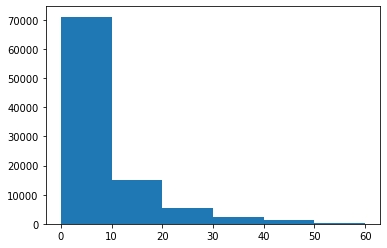

In [37]:
plot_degree_dist(G)

# [RQ2]

We take in input the starting node and the number of clicks $d$, then starting from initial node we reach all the node at level $k$  with $k\leq d$ considering the starting node as level 0.

In [11]:
def clicks(graph, start_node, depth):
    visited = [start_node] #the starting node is the first visited node
    for i in range(depth): #until level d 
        all_visited =[] # all the nodes visited
        for node in visited:
            for nbr in graph[node]: #for all the neighborhood  of node
                all_visited.append(nbr)  #save the neighborhood in the list 
        visited = all_visited#saving all the neighborhood     
    return set(all_visited) #returning a set to avoid ripetitions

As an example we can compute all the pages reachable starting from node 95 with 3 clicks:

In [14]:
data_name.iloc[list(clicks(G, 95, 3))].head()

,Pages
Node,
1595904,Reba McEntire
1182721,Ma (album)
1061891,Jodie Foster
1067523,Valentine (film)
1060361,Rose McGowan


# RQ3

In [271]:
maximo = 1000000000000000
indexa = 0
for element, index in new_dat2.iterrows():
    print(len(new_dat2.loc[element,"PageList"]), index)

5074 Category                                  English_footballers
PageList    [22860, 28961, 28979, 29264, 30896, 30900, 319...
Name: 0, dtype: object
5635 Category                                Year_of_birth_missing
PageList    [28411, 72580, 74377, 76045, 76100, 92872, 928...
Name: 1, dtype: object
4925 Category                          The_Football_League_players
PageList    [29573, 33973, 48714, 54184, 72483, 72521, 725...
Name: 2, dtype: object
5937 Category                                Year_of_death_missing
PageList    [29582, 72518, 72528, 72579, 72587, 72591, 726...
Name: 3, dtype: object
5406 Category                       Association_football_defenders
PageList    [48583, 72549, 72617, 72629, 72943, 73090, 731...
Name: 4, dtype: object
5571 Category                        Association_football_forwards
PageList    [72522, 72622, 72696, 72824, 72945, 73060, 731...
Name: 5, dtype: object
6775 Category                     Association_football_midfielders
PageList    [73066, 7

We ask for a category as input, then we search for this category in the dataframe containing all the categories and if the category falls, we insert all the pages associated with that category in the set "nodes". Then we return either the set nodes or if the category is not present in the dataframe the string "No Category"

In [288]:
new_dat2

,Category,PageList
0,English_footballers,"[22860, 28961, 28979, 29264, 30896, 30900, 319..."
1,Year_of_birth_missing,"[28411, 72580, 74377, 76045, 76100, 92872, 928..."
2,The_Football_League_players,"[29573, 33973, 48714, 54184, 72483, 72521, 725..."
3,Year_of_death_missing,"[29582, 72518, 72528, 72579, 72587, 72591, 726..."
4,Association_football_defenders,"[48583, 72549, 72617, 72629, 72943, 73090, 731..."
5,Association_football_forwards,"[72522, 72622, 72696, 72824, 72945, 73060, 731..."
6,Association_football_midfielders,"[73066, 73120, 73122, 75211, 75212, 75227, 752..."
7,Place_of_birth_missing_(living_people),"[75430, 603936, 75195, 83446, 86747, 96768, 36..."
8,Members_of_the_United_Kingdom_Parliament_for_E...,"[535217, 536702, 536701, 538562, 538800, 53913..."
9,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,..."


## What Category?

In [372]:
def category(df):
    nodes = list() #Create an empty list  
    C = input("Enter your Category: ") #We ask as input a Category
    for i in range(len(df)): #For each row in our dataframe containing category and page lsit
        if df.loc[i,'Category'] == C: #If the category that we put in input is equal to category in i-th row
            nodes = df.loc[i,"PageList"] #We increase our nodes list with all ele
    if not nodes: #If nodes list is empty
        print("No Category") #Category not appear in our dataframe
    else:
        return list(map(int, nodes)) #Map every element in list nodes to int

In [373]:
nodes = category(new_dat2)

Enter your Category: American_film_actors


In [374]:
nodes

[343966,
 633296,
 725183,
 744132,
 1054490,
 1054933,
 1060651,
 1064082,
 1162421,
 1162580,
 1261800,
 1373051,
 1505728,
 1659467,
 572798,
 1235828,
 1247269,
 1263510,
 1268321,
 1268555,
 1268586,
 1269604,
 1270563,
 1618809,
 174,
 1088,
 1121,
 1124,
 1133,
 1134,
 1136,
 1139,
 1143,
 1153,
 15182,
 24166,
 25689,
 26503,
 30849,
 30850,
 31888,
 32569,
 35315,
 39423,
 53906,
 70483,
 71575,
 71682,
 71740,
 71744,
 94225,
 108143,
 108208,
 108261,
 108941,
 110138,
 110144,
 110145,
 110162,
 110163,
 110164,
 110175,
 110176,
 110181,
 110182,
 110200,
 110209,
 110407,
 110410,
 112148,
 113195,
 113199,
 113206,
 113216,
 113258,
 113283,
 113343,
 132133,
 133703,
 133704,
 134102,
 134104,
 134109,
 134120,
 134260,
 134272,
 134287,
 134348,
 134361,
 134364,
 134827,
 135016,
 135022,
 135023,
 135035,
 135038,
 135045,
 135136,
 135763,
 136065,
 136176,
 136276,
 136382,
 136480,
 136535,
 136584,
 136595,
 136596,
 136607,
 137138,
 137768,
 138066,
 139762,
 1

## Degree Centrality

For the list of nodes obtained for the specific category, let's search for the most central node. We use degree-centrality as a measure of centrality. We get the degree-centrality with respect to the entire graph and then we return a dictionary containing as keys the nodes of the specific category and for each node its own centrality, finally we get the dictionary key with the maximum value. The key obtained represents centrality

In [375]:
import networkx as nx
import operator
def degree_centrality(G,nodes): 
    dictionary = {}
    tot_graph = nx.degree_centrality(G)
    for keys,value in tot_graph.items():
        if int(keys) in nodes:
            dictionary.update({keys: value})
    v = max(dictionary, key=dictionary.get)
    return v
            
    

In [376]:
v=degree_centrality(G,nodes)

In [377]:
v

1061501

## Find Minimum Distance

In [384]:
def minimum_distance(graph,start,goal):
    shortest = {}
    shortest[start] = 0
    visited = set([start])
    neighbour = set(graph.neighbors(start))
    non_visited = set()
    start_distance = 0 
    while not all(x in visited for x in goal):
        visited = visited.union(neighbour)
        while len(neighbour) > 0:
            current_vertex = neighbour.pop() 
            if (current_vertex in goal) and (current_vertex not in shortest.keys()):
                shortest[current_vertex] = start_distance + 1 
            for element in set(graph.neighbors(current_vertex)):
                if element not in visited:
                    non_visited.add(element)
        
        if len(non_visited) == 0:
            break
        neighbour = non_visited
        non_visited = set()
        start_distance += 1
       
    print("Partial number Click obtained before the node on which one has arrived has no more neighbors is:", start_distance)
    if nx.is_weakly_connected(G) == False:
        return print("Not Possible because Graph is not Connected")
    else:
        if (nodes - shortest.keys()) != 0:
            print("From the start nodes", v, " we can't reach all pages in nodes")
        else:
            print("From the start nodes", v, "reach all pages in nodes with number of click", start_distance)
   
            
   

In [385]:
minimum_distance(G,v,nodes)

Partial number Click obtained before the node on which one has arrived has no more neighbors is: 22
Not Possible because Graph is not Connected


# [RQ4]
### Step 1 : costructing the subgraph of C1 and C2
To answer question 4 first of all we need to build the subgraph induced by the categories selected, the new graph contains the node of C1 and C2 and all the edges among the nodes of these two categories

In [31]:
def sub_graph (graph, c1, c2):
    
    c1_nodes = new_dat[new_dat['Category']== c1]['PageList']     #nodes of c1
    lst1 = [int(val) for sublist in c1_nodes for val in sublist] #list of nodes of c1
    
    c2_nodes = new_dat[new_dat['Category']== c2]['PageList']     #nodes of c2
    lst2 = [int(val) for sublist in c2_nodes for val in sublist] #list of nodes of c2
    
    nodes = lst1+lst2 #list of the nodes of c1 AND c2
    
    sub_graph = graph.subgraph(nodes).copy() #building the subgraph
    
    return nx.DiGraph(sub_graph)

In [43]:
C1 = input("Enter the first Category: ")
C2 = input("Enter the second Category: ")

Enter the first Category: Association_football_forwards
Enter the second Category: Association_football_midfielders


In [44]:
G_sub = sub_graph(G, C1,C2)

In [45]:
nx.info(G_sub)

'Name: \nType: DiGraph\nNumber of nodes: 5266\nNumber of edges: 7430\nAverage in degree:   1.4109\nAverage out degree:   1.4109'

### Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?
This is a <b> min cut </b> problem : we want to find the minimum number of edges to remove in order to disconect two given nodes in the graph. <br>
We can solve this problem using two main results:
- Max-flow min-cut theorem
- Ford_Fulkerson algorithm <br>
The theorem asserts that <i>the maximum amount of flow passing from the source to the sink is equal to the total weight of the edges in a minimum cut</i> and the algorithm can find the maximum flow so the minimum cut.

#### Ford_Fulkerson algorithm
This algorithm needs the support of a BFS algorithm that returns the path from the node u to node v, if it exists. The idea behind the algorithm is as follows: as long as there is a path from the source (start node) to the sink (end node), with available capacity on all edges in the path, we send flow along one of the paths. Then we find another path, and so on.

In [46]:
def ford_fulkerson(graph, s, t):
    
    n = len(graph)
    INF = float('Inf')
    max_flow = 0
 
    f = [[0 for k in range(n)] for i in range(n)] #flow matrix
 
    while True:  # while there is a path from s to t 
        # Use BFS to find s-t path 
        prev = [ -1 for _ in range(n) ] # This array is filled by BFS and to store path
        prev[s] = -2 # s marked as visited
        q = deque()
        q.append(s) # s is visited
 
        while q and prev[t] == -1: #while q is not empty and t is not visited
            u = q.popleft() #visit u
            for v in range(n):
                path_flow = graph[u][v] - f[u][v]  # path_flow = graph(u,v) - f(u,v) for the edge (u,v)
                if path_flow > 0 and prev[v] == -1: #if is possible to have a path and v is not visited
                    q.append(v) #visit v
                    prev[v] = u #store u in index v
 
        if prev[t] == -1:   # if t has not been visited
            break
 
        # augment s-t path in residual graph that has been found by BFS
        v = t
        delta = INF
        while True:
            u = prev[v]
            path_flow = graph[u][v] - f[u][v]
            delta = min(delta, path_flow)
            v = u
            if v == s:
                break
 
        v = t
        while True:
            u = prev[v]
            f[u][v] += delta #increase the flow
            f[v][u] -= delta #decrease the flow
            v = u
            if v == s:
                break
 
        max_flow += delta
 
    return max_flow #min_cut

In order to give an efficient implementation of the algorithm we map the nodes of G_sub into [0,...,len(G_sub.nodes)] and then, we build the adjacency matrix associated at this graph. The function _nx.adjacency_matrix()_ provided by networkx library returns a sparse matrix that we can convert in a numpy matrix using _.toarray()_ .

In [47]:
#Mapping G_sub into [0,...,len(G_sub.nodes)]
mapping = {old_label:new_label for new_label, old_label in enumerate(G_sub.nodes())}
H_sub = nx.relabel_nodes(G_sub, mapping)

In [48]:
#Sparse adjacency matrix
Adj_Mat_sparse = nx.adjacency_matrix(H_sub)

In [49]:
#Numpy adjacency matrix
Adj_Mat = Adj_Mat_sparse.toarray()

In [71]:
#Nodes u and v of H_sub picked at random
u = choice(list(H_sub.nodes))
v = choice(list(H_sub.nodes))

In [35]:
min_cut = ford_fulkerson(Adj_Mat, u, v)
min_cut

1